# Наша сеть на основе погоды

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd



In [2]:
# Скачивание датасета и его настройка
df = pd.read_csv('df_finish_all_attr.csv')
df = df[df.config > 0]
df

,Unnamed: 0,MessageReceivedDate,baggage,hour,minute,day_of_the_week,config,rate
0,0,2023-08-31 22:35:00,3,22,35,Thursday,131,0.022901
1,1,2023-08-31 22:40:00,5,22,40,Thursday,131,0.038168
2,2,2023-08-31 22:45:00,8,22,45,Thursday,131,0.061069
3,3,2023-08-31 22:50:00,2,22,50,Thursday,131,0.015267
4,4,2023-08-31 22:55:00,1,22,55,Thursday,131,0.007634
...,...,...,...,...,...,...,...,...
3391478,3391478,2023-07-02 21:45:00,0,21,45,Sunday,230,0.000000
3391479,3391479,2023-07-02 21:50:00,0,21,50,Sunday,230,0.000000
3391480,3391480,2023-07-02 21:55:00,4,21,55,Sunday,230,0.017391
3391481,3391481,2023-07-02 22:00:00,1,22,0,Sunday,230,0.004348


In [3]:
# Взяли необохдимые нам столбцы
df = df[['MessageReceivedDate', 'rate']]
df

,MessageReceivedDate,rate
0,2023-08-31 22:35:00,0.022901
1,2023-08-31 22:40:00,0.038168
2,2023-08-31 22:45:00,0.061069
3,2023-08-31 22:50:00,0.015267
4,2023-08-31 22:55:00,0.007634
...,...,...
3391478,2023-07-02 21:45:00,0.000000
3391479,2023-07-02 21:50:00,0.000000
3391480,2023-07-02 21:55:00,0.017391
3391481,2023-07-02 22:00:00,0.004348


In [4]:
# Создали таблицу данных
features_considered = ['rate']
uni_data = df[features_considered]
uni_data.index = df['MessageReceivedDate']
uni_data

,rate
MessageReceivedDate,
2023-08-31 22:35:00,0.022901
2023-08-31 22:40:00,0.038168
2023-08-31 22:45:00,0.061069
2023-08-31 22:50:00,0.015267
2023-08-31 22:55:00,0.007634
...,...
2023-07-02 21:45:00,0.000000
2023-07-02 21:50:00,0.000000
2023-07-02 21:55:00,0.017391


In [5]:
# На основе количества строк. Cоздаём переменную TRAIN_SPLIT и даём ей 70 процентов от Датасета для обучения. Для обеспечения воспроизводимости результатов устанавливается функция seed.
TRAIN_SPLIT = 250000
tf.random.set_seed(13)

array([<Axes: xlabel='MessageReceivedDate'>], dtype=object)

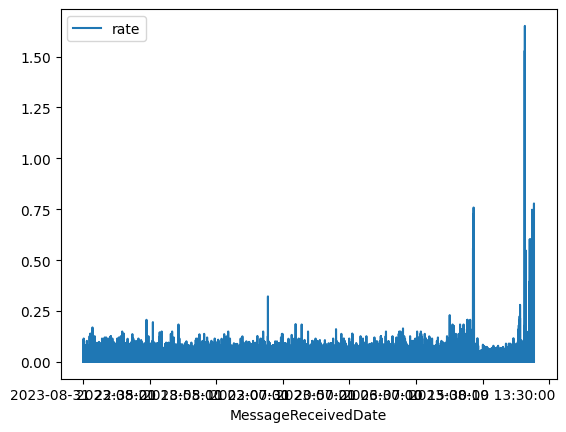

In [8]:
uni_data.plot(subplots=True)

In [9]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  """Функция возвращает временные интервалы для обучения модели.
  start_index - индекс с которого начинается
  end_index - индекс с которого заканчивается
  history_size — это размер последнего временного интервала
  target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать
  """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [10]:
uni_data = uni_data.values
uni_data

array([[0.02290076],
       [0.03816794],
       [0.0610687 ],
       ...,
       [0.0173913 ],
       [0.00434783],
       [0.00434783]])

In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [12]:
# Выполняем стандартизацию данных.
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [13]:
# На вход в модель будут подаваться последние 20 зарегистрированных наблюдений, и модель необходимо обучить прогнозировать  на следующем шаге по времени.
# univariate_past_history = 20
univariate_past_history = 100
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [14]:
# создание шагов
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
# Создание и выдача графика
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

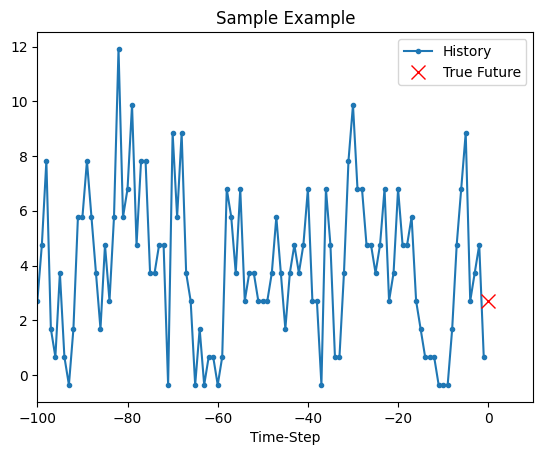

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [17]:
# Создание среднего. Функция смотрит историю и берёт среднее из всех значений
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

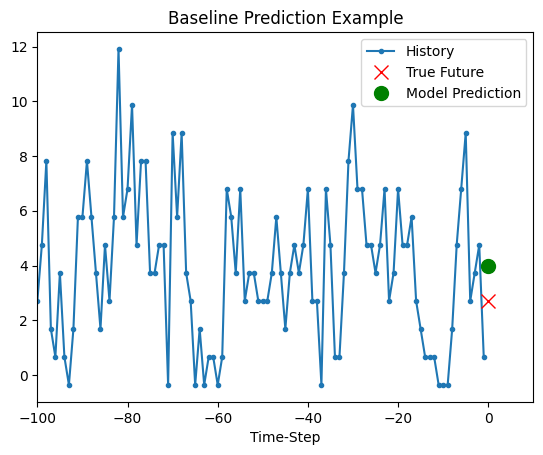

In [18]:

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [19]:
# Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [21]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 1s 10ms/step
(256, 1)


In [22]:
# Из-за большого размера набора данных и в целях экономии времени каждая эпоха будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 15s 62ms/step - loss: 0.4318 - val_loss: 0.3228
Epoch 2/10
200/200 [==============================] - 10s 48ms/step - loss: 0.3017 - val_loss: 0.3137
Epoch 3/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2980 - val_loss: 0.3097
Epoch 4/10
200/200 [==============================] - 9s 43ms/step - loss: 0.3153 - val_loss: 0.3079
Epoch 5/10
200/200 [==============================] - 10s 52ms/step - loss: 0.3481 - val_loss: 0.3082
Epoch 6/10
200/200 [==============================] - 17s 86ms/step - loss: 0.3235 - val_loss: 0.3064
Epoch 7/10
200/200 [==============================] - 9s 47ms/step - loss: 0.2909 - val_loss: 0.3059
Epoch 8/10
200/200 [==============================] - 10s 50ms/step - loss: 0.2933 - val_loss: 0.3052
Epoch 9/10
200/200 [==============================] - 9s 47ms/step - loss: 0.3113 - val_loss: 0.3052
Epoch 10/10
200/200 [==============================] - 10s 48ms/step - loss: 0.3500 -

8/8 [==============================] - 0s 8ms/step


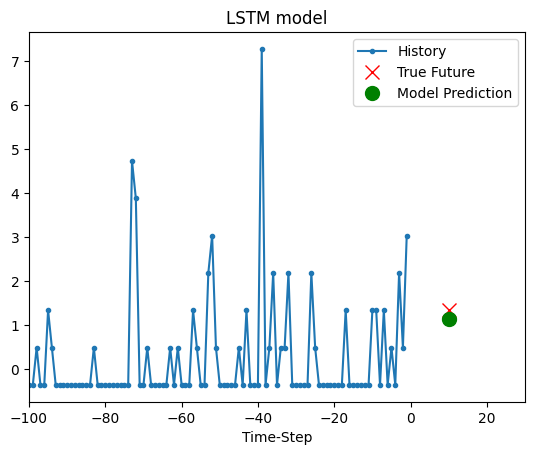

8/8 [==============================] - 0s 8ms/step


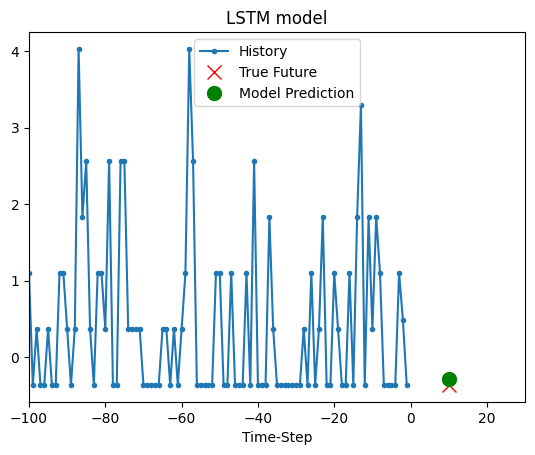

8/8 [==============================] - 0s 9ms/step


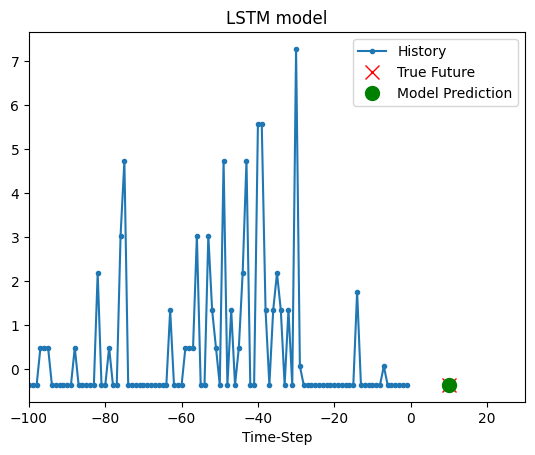

In [23]:
# После выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 10, 'LSTM model')
  plot.show()